# Titanic: Predicting survivors using Random Forest Classifiers

### Importing libraries

In [1474]:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import joblib
import re

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

plt.style.use('ggplot')
sns.set_palette('muted')

import warnings
warnings.filterwarnings('ignore')


# Set display options to show all columns of a dataframe
pd.set_option('display.max_columns', None)

### Loading data

In [1475]:
test_data_raw = pd.read_csv('test.csv')
train_data_raw = pd.read_csv('train.csv')

In [1476]:
train_data_raw

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [1477]:
split_point = train_data_raw.shape[0]

### Step 1: Data understanding

In [1478]:
df = train_data_raw.copy()
test_submission_df = test_data_raw.copy()
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [1479]:
test_submission_df

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [1480]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [1481]:
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

#### General:

In [1482]:
df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

No duplicated values.

In [1483]:
df.loc[df.duplicated()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


In [1484]:
test_submission_df.loc[test_submission_df.duplicated()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


In [1485]:
# Changing object data type to string in the dataframe
obj_features = df.select_dtypes(include='object').columns
df[obj_features] = df[obj_features].astype('string')
test_submission_df[obj_features] = test_submission_df[obj_features].astype('string')

In [1486]:
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,<NA>,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,<NA>,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,<NA>,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,<NA>,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,<NA>,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


#### Age:
The Age column as 20% missing data.

In [1487]:
missing = df['Age'].isna().sum()
print('Missing age data: {}'.format(missing))
print('Percentage missing: {}'.format(missing/df.shape[0]*100))

Missing age data: 177
Percentage missing: 19.865319865319865


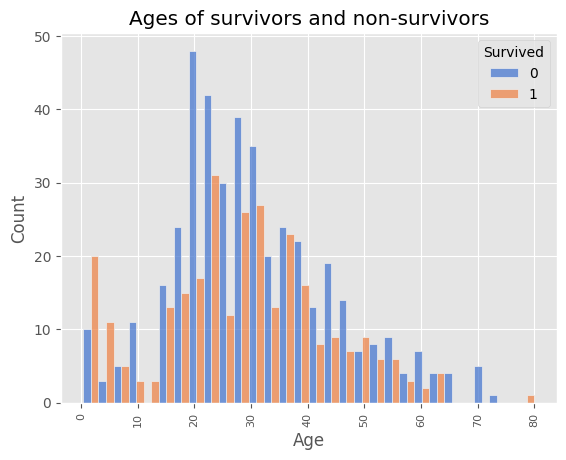

In [1488]:
column_x = 'Age'
sns.histplot(data= df, x=column_x, hue='Survived',multiple='dodge',bins=30)
plt.xlabel(column_x.title(),fontsize=12)
plt.xticks(rotation=90, fontsize=8)
plt.ylabel('Count',fontsize=12)
plt.title('Ages of survivors and non-survivors')
# Get the current legend
legend = plt.gca().get_legend()
legend.set_title('Survived')
plt.show()

#### Fare:
Fare has one missing value.

In [1489]:
df.loc[df['Fare'].isna()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked


In [1490]:
test_submission_df.loc[test_submission_df['Fare'].isna()]

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,<NA>,S


This passenger was in the 3rd class. Replacing this missing fare value with the mean of all fares payed by 3rd class passengers.

In [1491]:
m = test_submission_df.query('Pclass == 3')['Fare'].mean()
m = format(m, '.4f')
test_submission_df.loc[test_submission_df['Fare'].isna(), 'Fare'] = m
test_submission_df.query('PassengerId == 1044')

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,12.4597,<NA>,S


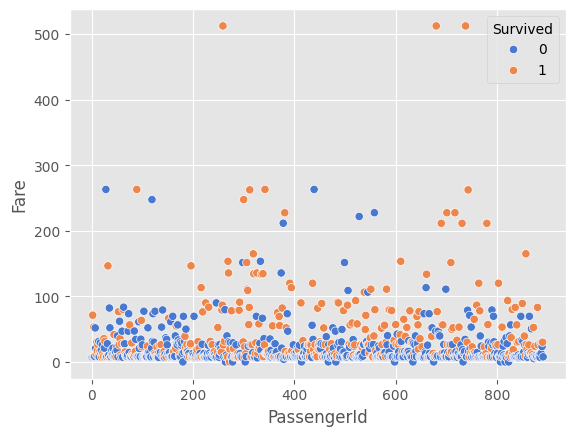

In [1492]:
sns.scatterplot(data = df, x='PassengerId', y='Fare', hue='Survived')
plt.show()

#### Cabin:

Cabin has 77% missing data. However the fact that a cabin number has been recorded seems to favour survivorship.

In [1493]:
df['Cabin'].value_counts(dropna=False)

Cabin
<NA>           687
G6               4
B96 B98          4
C23 C25 C27      4
F33              3
              ... 
C95              1
B101             1
B3               1
E77              1
C148             1
Name: count, Length: 148, dtype: Int64

In [1494]:
missing = df['Cabin'].isna().sum()
print('Missing cabin data: {}'.format(missing))
print('Percentage missing: {}'.format(missing/df.shape[0]*100))

Missing cabin data: 687
Percentage missing: 77.10437710437711


Checking if cabin letter has anything to do with passenger class and hence survival rate.

In [1495]:
df['Cabin_Letter'] = df['Cabin'].map(lambda cabin: str(cabin)[0]).astype('string')
test_submission_df['Cabin_Letter'] = test_submission_df['Cabin'].map(lambda cabin: str(cabin)[0]).astype('string')
df['Cabin_Letter'].value_counts()

Cabin_Letter
<    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: count, dtype: Int64

In [1496]:
df['Survived'].groupby(df['Cabin_Letter']).mean()

Cabin_Letter
<    0.299854
A    0.466667
B    0.744681
C    0.593220
D    0.757576
E    0.750000
F    0.615385
G    0.500000
T    0.000000
Name: Survived, dtype: float64

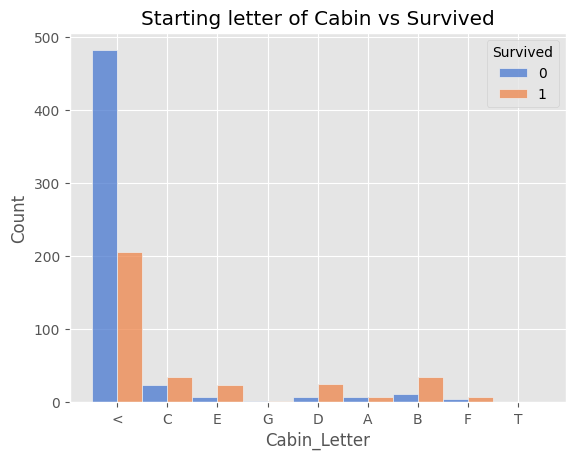

In [1497]:
sns.histplot(data = df, x = 'Cabin_Letter', hue='Survived', multiple='dodge')
plt.title('Starting letter of Cabin vs Survived')
plt.show()

Based on the above chart, it's a good idea to either have a binary representation on whether the individual has a record for cabin or not. Or just one-hot-encode this feature.

#### PassengerId:
Dropping this column.

In [1498]:
df.drop(columns=['PassengerId'], inplace=True)
test_submission_df.drop(columns=['PassengerId'], inplace=True)

#### Name:

##### Name Title

Extracting title from these names in the hope that some titles might seem "important". The title appears with the '.' in Name.

In [1499]:
df

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_Letter
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,<NA>,S,<
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,<NA>,S,<
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,C
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,<NA>,S,<
...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,<NA>,S,<
887,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,B
888,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,<NA>,S,<
889,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,C


In [1500]:
df['Name_Title'] = df['Name'].map(lambda name: re.search(r'\w*\.', name).group()).astype('string') 
test_submission_df['Name_Title'] = test_submission_df['Name'].map(lambda name: re.search(r'\w*\.', name).group()).astype('string') 
df['Name_Title'].value_counts()

Name_Title
Mr.          517
Miss.        182
Mrs.         125
Master.       40
Dr.            7
Rev.           6
Major.         2
Col.           2
Mlle.          2
Countess.      1
Capt.          1
Ms.            1
Sir.           1
Lady.          1
Mme.           1
Don.           1
Jonkheer.      1
Name: count, dtype: Int64

In [1501]:
df['Survived'].groupby(df['Name_Title']).mean().sort_values(ascending=False)

Name_Title
Sir.         1.000000
Countess.    1.000000
Ms.          1.000000
Mme.         1.000000
Lady.        1.000000
Mlle.        1.000000
Mrs.         0.792000
Miss.        0.697802
Master.      0.575000
Col.         0.500000
Major.       0.500000
Dr.          0.428571
Mr.          0.156673
Jonkheer.    0.000000
Don.         0.000000
Rev.         0.000000
Capt.        0.000000
Name: Survived, dtype: float64

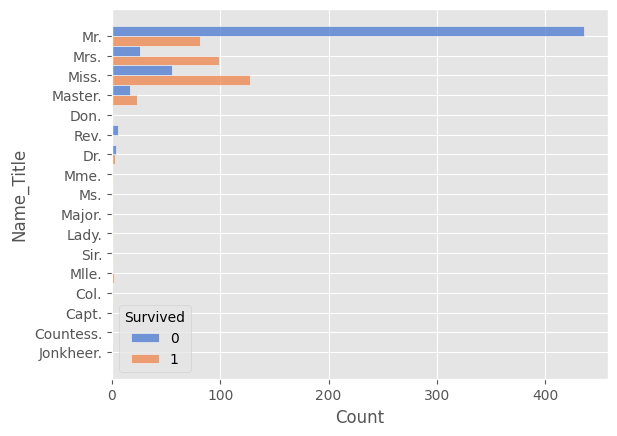

In [1502]:
sns.histplot(data = df, y='Name_Title', hue='Survived', multiple='dodge')
plt.show()

##### Length of the name

Length of the name also seems to be a factor. Longer the name, higher the chances of survival. Dividing the length of name into 5 bins with roughly equal number of people and checking their rate of survival.

In [1503]:
df['Name_Length'] = df['Name'].map(lambda name: len(name))
test_submission_df['Name_Length'] = test_submission_df['Name'].map(lambda name: len(name))
df['Survived'].groupby(pd.qcut(df['Name_Length'], 5)).mean()

Name_Length
(11.999, 19.0]    0.220588
(19.0, 23.0]      0.301282
(23.0, 27.0]      0.319797
(27.0, 32.0]      0.442424
(32.0, 82.0]      0.674556
Name: Survived, dtype: float64

#### Embarked:
2 unnacounted for, filled missing data with 'S' since that is most common and the statistics after replacement change less than 1%.

In [1504]:
df['Embarked'].value_counts(dropna=False)

Embarked
S       644
C       168
Q        77
<NA>      2
Name: count, dtype: Int64

In [1505]:
# Nothing missing in test data
test_submission_df['Embarked'].value_counts(dropna=False)

Embarked
S    270
C    102
Q     46
Name: count, dtype: Int64

In [1506]:
df.loc[df['Embarked'].isna(), 'Embarked'] = 'S'
df['Embarked'].value_counts(dropna=False)

Embarked
S    646
C    168
Q     77
Name: count, dtype: Int64

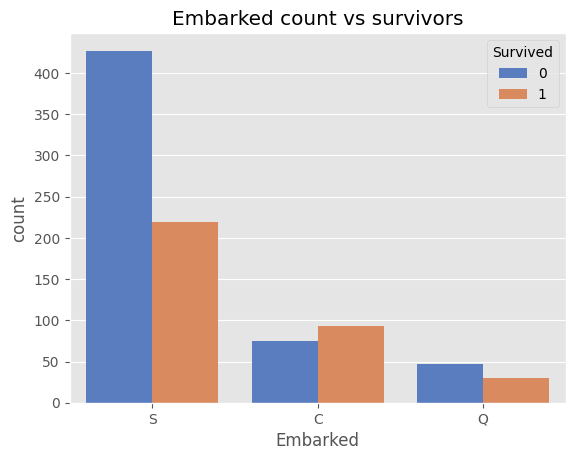

In [1507]:
ax = sns.countplot(data=df, x='Embarked', hue='Survived')
ax.set_title('Embarked count vs survivors')
plt.show()

#### PClass:

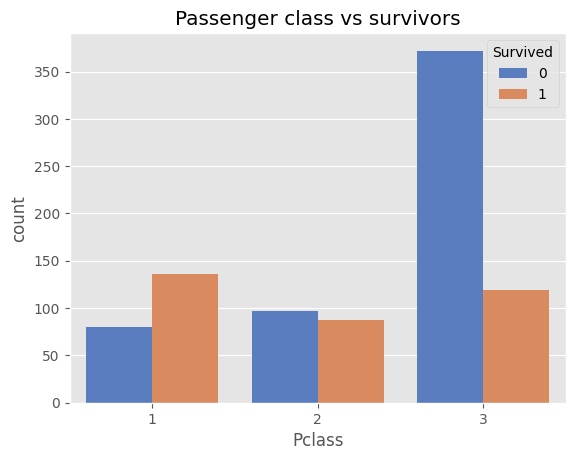

In [1508]:
ax = sns.countplot(data=df, x='Pclass', hue='Survived')
ax.set_title('Passenger class vs survivors')
plt.show()

#### Ticket:

Ticket length could give us some info.

In [1509]:
df['Ticket'].value_counts(dropna=False)

Ticket
347082              7
1601                7
CA. 2343            7
3101295             6
CA 2144             6
                   ..
2683                1
SOTON/O2 3101287    1
11774               1
392092              1
370376              1
Name: count, Length: 681, dtype: Int64

In [1510]:
df[df['Ticket'].isna()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_Letter,Name_Title,Name_Length


In [1511]:
test_submission_df[test_submission_df['Ticket'].isna()]

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_Letter,Name_Title,Name_Length


In [1512]:
df['Ticket_Length'] = df['Ticket'].map(lambda ticket : len(ticket))
test_submission_df['Ticket_Length'] = test_submission_df['Ticket'].map(lambda ticket : len(ticket))
df['Survived'].groupby(pd.qcut(df['Ticket_Length'], 4)).mean()

Ticket_Length
(2.999, 5.0]    0.504274
(5.0, 6.0]      0.319809
(6.0, 7.0]      0.296296
(7.0, 18.0]     0.388626
Name: Survived, dtype: float64

#### Siblings/Spouse and Parents/Children:

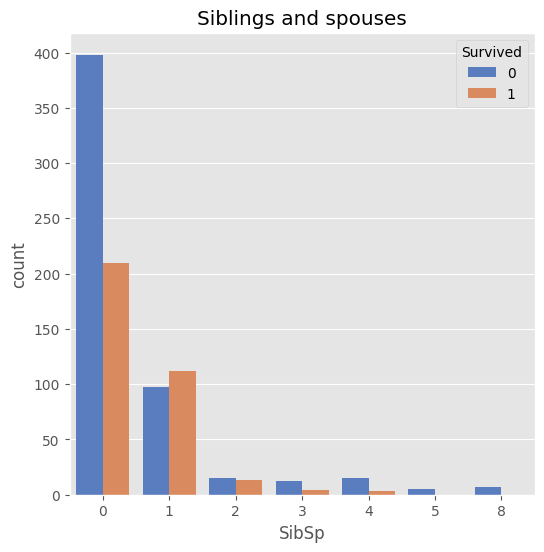

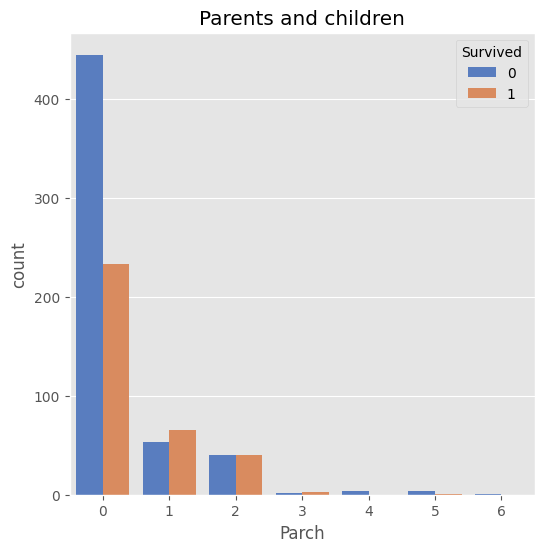

In [1513]:
plt.figure(figsize=(6,6))
ax = sns.countplot(data=df, x='SibSp', hue='Survived')
ax.set_title('Siblings and spouses')


plt.figure(figsize=(6,6))
ax = sns.countplot(data=df, x='Parch', hue='Survived')
ax.set_title('Parents and children')

plt.show()

#### Gender:
Females have a higer survival rate.

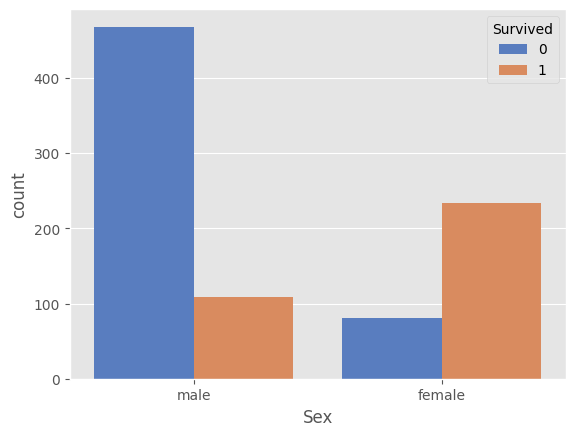

In [1514]:
sns.countplot(data=df, x='Sex', hue='Survived')
plt.show()

### Step 2: Data Preparation

In [1515]:
df

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_Letter,Name_Title,Name_Length,Ticket_Length
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,<NA>,S,<,Mr.,23,9
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,C,Mrs.,51,8
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,<NA>,S,<,Miss.,22,16
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,C,Mrs.,44,6
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,<NA>,S,<,Mr.,24,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,<NA>,S,<,Rev.,21,6
887,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S,B,Miss.,28,6
888,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,<NA>,S,<,Miss.,40,10
889,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,C,Mr.,21,6


In [1516]:
test_submission_df

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_Letter,Name_Title,Name_Length,Ticket_Length
0,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,<NA>,Q,<,Mr.,16,6
1,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0,<NA>,S,<,Mrs.,32,6
2,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,<NA>,Q,<,Mr.,25,6
3,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,<NA>,S,<,Mr.,16,6
4,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,<NA>,S,<,Mrs.,44,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.05,<NA>,S,<,Mr.,18,9
414,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9,C105,C,C,Dona.,28,8
415,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.25,<NA>,S,<,Mr.,28,18
416,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.05,<NA>,S,<,Mr.,19,6


#### Age:

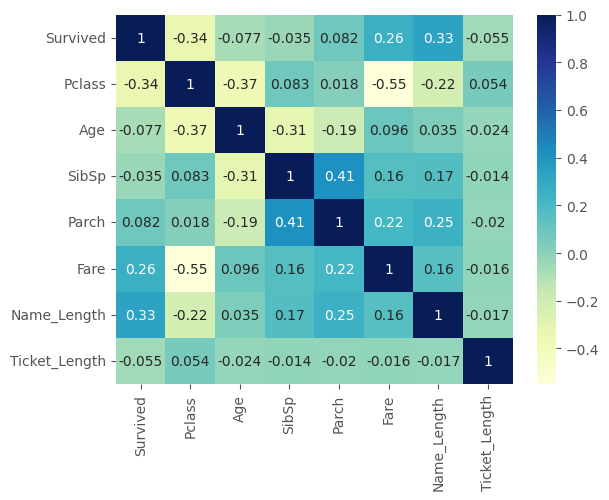

In [1517]:
sns.heatmap(df.corr(numeric_only = True), annot=True, cmap='YlGnBu')
plt.show()

In [1518]:
df['Age'].describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

In [1519]:
print('Missing data in train and test data respectively: {}, {}'.format(df['Age'].isna().sum(), test_submission_df['Age'].isna().sum()))

Missing data in train and test data respectively: 177, 86


Imputing age with mean is the simplest way to do this. However, more information can be gained from the title of "Miss, Master, Mrs. and Mr." regarding their age. For other titles eg Lady, Countess, Dr., we will do with the mean age of Mrs. or Mr. according to gender. 

In [1520]:
def age_imputer(dataframe):
    
    # Calculate the average age for each main title
    main_title = ['Mr.', 'Mrs.', 'Miss.', 'Master.']
    average_age_by_title = dataframe[dataframe['Name_Title'].isin(main_title)].groupby('Name_Title')['Age'].transform('mean')

    # Calculate the average age for 'Mr.' and 'Mrs.' to be used for other titles
    average_age_mr = dataframe[dataframe['Name_Title'] == 'Mr.']['Age'].mean()
    average_age_mrs = dataframe[dataframe['Name_Title'] == 'Mrs.']['Age'].mean()

    # Create a mask for rows with main titles
    main_title_mask = dataframe['Name_Title'].isin(main_title)

    # Fill missing values for main titles
    dataframe.loc[main_title_mask, 'Age'] = dataframe.loc[main_title_mask, 'Age'].fillna(average_age_by_title)

    # Fill missing values for other based on gender
    dataframe.loc[~main_title_mask & (dataframe['Sex'] == 'male'), 'Age'] =\
                    dataframe.loc[~main_title_mask & (dataframe['Sex'] == 'male'), 'Age'].fillna(average_age_mr)
    dataframe.loc[~main_title_mask & (dataframe['Sex'] == 'female'), 'Age'] =\
                    dataframe.loc[~main_title_mask & (dataframe['Sex'] == 'female'), 'Age'].fillna(average_age_mrs)
    
    dataframe['Age'] = dataframe['Age'].round(2)                
    
    return dataframe                

In [1521]:
df = age_imputer(df)
test_submission_df = age_imputer(test_submission_df)

### Step 3: Feature Engineering

In [1522]:
df

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_Letter,Name_Title,Name_Length,Ticket_Length
0,0,3,"Braund, Mr. Owen Harris",male,22.00,1,0,A/5 21171,7.2500,<NA>,S,<,Mr.,23,9
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.00,1,0,PC 17599,71.2833,C85,C,C,Mrs.,51,8
2,1,3,"Heikkinen, Miss. Laina",female,26.00,0,0,STON/O2. 3101282,7.9250,<NA>,S,<,Miss.,22,16
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00,1,0,113803,53.1000,C123,S,C,Mrs.,44,6
4,0,3,"Allen, Mr. William Henry",male,35.00,0,0,373450,8.0500,<NA>,S,<,Mr.,24,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,"Montvila, Rev. Juozas",male,27.00,0,0,211536,13.0000,<NA>,S,<,Rev.,21,6
887,1,1,"Graham, Miss. Margaret Edith",female,19.00,0,0,112053,30.0000,B42,S,B,Miss.,28,6
888,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,21.77,1,2,W./C. 6607,23.4500,<NA>,S,<,Miss.,40,10
889,1,1,"Behr, Mr. Karl Howell",male,26.00,0,0,111369,30.0000,C148,C,C,Mr.,21,6


#### Pclass v Fare

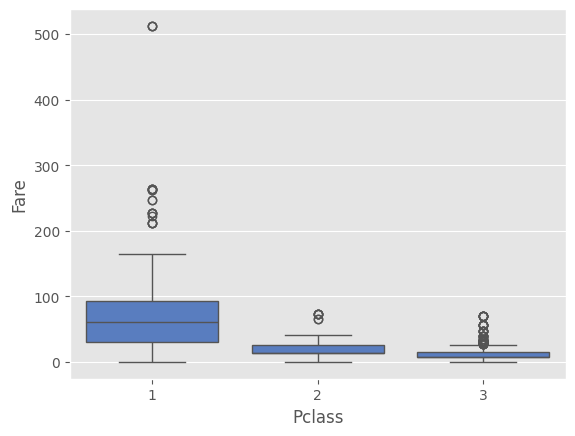

In [1523]:
sns.boxplot(data = df, x = 'Pclass', y='Fare')
plt.show()

#### Gender

Converting male to 1 and female to 0.

In [1524]:
df['Sex'] = df['Sex'].map(lambda gender: 0 if gender == 'female' else 1)
test_submission_df['Sex'] = test_submission_df['Sex'].map(lambda gender: 0 if gender == 'female' else 1)
df

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Cabin_Letter,Name_Title,Name_Length,Ticket_Length
0,0,3,"Braund, Mr. Owen Harris",1,22.00,1,0,A/5 21171,7.2500,<NA>,S,<,Mr.,23,9
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.00,1,0,PC 17599,71.2833,C85,C,C,Mrs.,51,8
2,1,3,"Heikkinen, Miss. Laina",0,26.00,0,0,STON/O2. 3101282,7.9250,<NA>,S,<,Miss.,22,16
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.00,1,0,113803,53.1000,C123,S,C,Mrs.,44,6
4,0,3,"Allen, Mr. William Henry",1,35.00,0,0,373450,8.0500,<NA>,S,<,Mr.,24,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,"Montvila, Rev. Juozas",1,27.00,0,0,211536,13.0000,<NA>,S,<,Rev.,21,6
887,1,1,"Graham, Miss. Margaret Edith",0,19.00,0,0,112053,30.0000,B42,S,B,Miss.,28,6
888,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",0,21.77,1,2,W./C. 6607,23.4500,<NA>,S,<,Miss.,40,10
889,1,1,"Behr, Mr. Karl Howell",1,26.00,0,0,111369,30.0000,C148,C,C,Mr.,21,6


#### Embarked

In [1525]:
# One hot encoding fixing dummy variable trap
# Could have used drop_first=True in the line below but chose to remove Embarked_Q as Q has the fewest passengers embarking and 
# its correlation to survivros is negligible.
def one_hot_embarked(df):
    dummies = pd.get_dummies(df['Embarked'], dtype='int', prefix = 'Embarked')
    df = pd.concat([df, dummies], axis = 1)
    df.drop(columns=['Embarked', 'Embarked_Q'], inplace=True)
    return df

In [1526]:
df = one_hot_embarked(df)
test_submission_df = one_hot_embarked(test_submission_df)

#### Family Size

Combining the two family size metrics (SibSp and Parch) into one. Adding the two into one and then categorising family size.

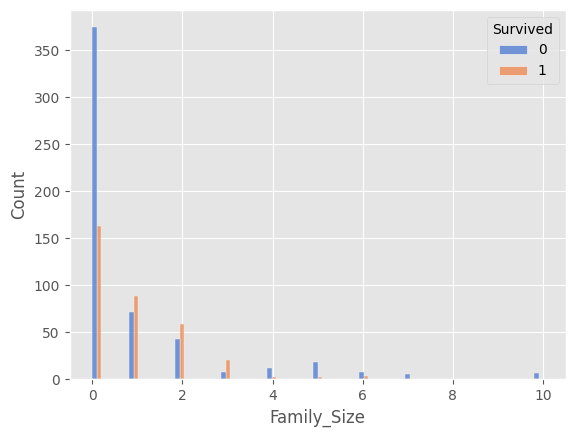

In [1527]:
df['Family_Size'] = df['SibSp']+df['Parch']
test_submission_df['Family_Size'] = test_submission_df['SibSp']+test_submission_df['Parch']
sns.histplot(data = df, x='Family_Size', hue='Survived', multiple='dodge')
plt.show()

Categorising family size to Solo (0), Nuclear (1 to 3) and Large (>3)

In [1528]:
def f(fam):
    if fam == 0:
        return 'Solo'
    if fam > 0 and fam <=3:
        return 'Nuclear'
    else:
        return 'Large'

df['Family_Size'] = df['Family_Size'].map(f)
test_submission_df['Family_Size'] = test_submission_df['Family_Size'].map(f)

One-hot encoding family size.

In [1529]:
def one_hot_family_size(df):
    dummies = pd.get_dummies(df['Family_Size'], dtype='int', prefix = 'Family_Size')
    df = pd.concat([df, dummies], axis = 1)
    df.drop(columns=['Family_Size', 'Family_Size_Large'], inplace=True)
    return df


df = one_hot_family_size(df)
test_submission_df = one_hot_family_size(test_submission_df)

#### Cabin

Tried to One-hot encode this separately. But the test set doesn't have cabin letters D, E. So combining datasets, one-hot-encoding and then splitting the datasets back.

In [1530]:
def one_hot_cabin_letter(df):
    dummies = pd.get_dummies(df['Cabin_Letter'], dtype='int', prefix='Cabin_Letter', drop_first=True)
    df = pd.concat([df, dummies], axis=1)
    df.drop(columns=['Cabin_Letter'], inplace=True)
    return df

joined_df = pd.concat([df, test_submission_df], axis=0)
joined_df = one_hot_cabin_letter(joined_df)

df = joined_df.iloc[:split_point]
test_submission_df = joined_df.iloc[split_point:]

#### Name_Title

One-hot encode this. Again, some  titles appear in the test set that don't appear in the train set so we combine them and one-hot-encode and split them apart.

In [1531]:
def one_hot_name_title(df):
    dummies = pd.get_dummies(df['Name_Title'], dtype='int', prefix = 'Name_Title')
    df = pd.concat([df, dummies], axis = 1)
    df.drop(columns=['Name_Title'], inplace=True)
    return df

joined_df = pd.concat([df, test_submission_df], axis=0)
joined_df = one_hot_name_title(joined_df)

df = joined_df.iloc[:split_point]
test_submission_df = joined_df.iloc[split_point:]

Dropping some features that won't be used.

In [1532]:
cols = ['Cabin', 'Name', 'Ticket']
df.drop(columns= cols, inplace=True)
test_submission_df.drop(columns= cols, inplace=True)

### Step 4: Scaling data

Since we are only testing out the Random Forest Classifier, we don't need to scale the data, as the classification is not distance based.

### Step 5: Implementing model

Splitting the train data into x_test and x_train as test dataset here does not have survivor info. So we need to check how the model is performing on part of the train set itself.

In [1535]:
shuffle_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_indices, test_indices in shuffle_split.split(df, df[['Survived', 'Sex', 'Pclass']]):
    x_train = df.loc[train_indices]
    x_test = df.loc[test_indices]

Also separating 'Survived' column from the test and train data.

In [1536]:
y_train = x_train['Survived']
x_train.drop(columns='Survived', inplace=True)
y_test = x_test['Survived']
x_test.drop(columns='Survived', inplace=True)

x_test_final = test_submission_df.drop(columns='Survived')

Using GridSearchCV for hyperparameter tuning.

In [1554]:
param_grid = [{'n_estimators': [20, 100, 200],
               'max_depth': [5, 7, 10, 15, None],
               'min_samples_split': [2, 3, 6, 8]}]

grid_search = GridSearchCV(estimator=RandomForestClassifier(), param_grid=param_grid, cv=5, return_train_score=True, verbose=True)
grid_search.fit(x_train, y_train)

#Save the model so you don't have to run Gridsearchcv again.
# Access the best model
best_model = grid_search.best_estimator_
best_parameters = grid_search.best_params_
best_score = grid_search.best_score_

# Save the best model to a file using joblib
joblib.dump(best_model, 'best_random_forest_model.pkl')

# Grid_search.cv_results_ is a dictonary of each iteration of grid search, saving parameters and test and train scores. 
# Converting that to a df and saving as a csv so can be accessed whenever.

cv_results_df = pd.DataFrame(grid_search.cv_results_)
cv_results_df.to_csv('cv_results.csv')

Fitting 5 folds for each of 60 candidates, totalling 300 fits


,param_max_depth,param_min_samples_split,param_n_estimators,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
42,15.0,6,20,0.832867,0.022326,1,0.927667,0.007076
7,5.0,6,100,0.830109,0.026024,2,0.854282,0.005471
8,5.0,6,200,0.830099,0.022000,3,0.853579,0.004039
1,5.0,2,100,0.830090,0.018168,4,0.855690,0.004829
10,5.0,8,100,0.828691,0.022567,5,0.852526,0.004072


In [1555]:
cv_results_df = pd.read_csv('cv_results.csv')

# Keeping only some important columns.
cv_results_df = cv_results_df[['param_max_depth', 'param_min_samples_split', 'param_n_estimators', 'mean_test_score', 'std_test_score', 'rank_test_score', 'mean_train_score', 'std_train_score']]

# Sorting the data by rank_test_score from best to worst.
cv_results_df.sort_values('rank_test_score', ascending=True).head()

,param_max_depth,param_min_samples_split,param_n_estimators,mean_test_score,std_test_score,rank_test_score,mean_train_score,std_train_score
42,15.0,6,20,0.832867,0.022326,1,0.927667,0.007076
7,5.0,6,100,0.830109,0.026024,2,0.854282,0.005471
8,5.0,6,200,0.830099,0.022000,3,0.853579,0.004039
1,5.0,2,100,0.830090,0.018168,4,0.855690,0.004829
10,5.0,8,100,0.828691,0.022567,5,0.852526,0.004072


In [1556]:
best_rfc = joblib.load('best_random_forest_model.pkl')
best_rfc.get_params

<bound method BaseEstimator.get_params of RandomForestClassifier(max_depth=15, min_samples_split=6, n_estimators=20)>

Now using the best RFC on the test data (of the training set) to see how it performs. (Is this even necessary given the crossvalidation score?) 

In [1557]:
y_pred = best_rfc.predict(x_test)
  
print("-----Test Data Accuracy----")
a_s = round(accuracy_score(y_test.to_numpy(), y_pred), 6)
print('Accuracy score:', a_s)
f_1 = round(f1_score(y_test.to_numpy(), y_pred), 6)
print('F1 score:', f_1)


-----Test Data Accuracy----
Accuracy score: 0.832402
F1 score: 0.776119


### Comments:

As can be seen from the lines below, something can be done about survivors who were predicted dead being mostly males. Model could be skewed to predict more males dying than females. Things that were tried to fix this:
1. New feature: PClass-Fare = (4 - PClass)*Fare to address that first class passengers pay more, but this ended up being highly correlated to Fare, so discarded.
2. High-Fare = 1 if fare>60, else 0. This simple feature made the model a tad worse. An increase in this particular misclassification by 1.

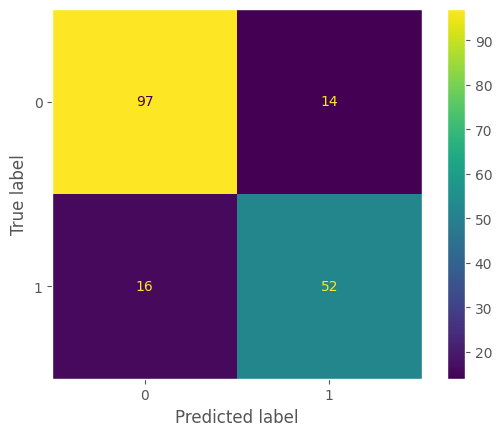

In [1558]:
CM_display = ConfusionMatrixDisplay(confusion_matrix = confusion_matrix(y_test, y_pred), display_labels = [0, 1])

CM_display.plot()
plt.grid(False) # Removes white grid lines that block numbers
plt.show() 

In [1559]:
test_temp = train_data_raw.iloc[test_indices]
test_temp['Predicted'] = y_pred
test_temp

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Predicted
119,120,0,3,"Andersson, Miss. Ellis Anna Maria",female,2.0,4,2,347082,31.2750,NaN,S,0.0
817,818,0,2,"Mallet, Mr. Albert",male,31.0,1,1,S.C./PARIS 2079,37.0042,NaN,C,0.0
484,485,1,1,"Bishop, Mr. Dickinson H",male,25.0,1,0,11967,91.0792,B49,C,1.0
67,68,0,3,"Crease, Mr. Ernest James",male,19.0,0,0,S.P. 3464,8.1583,NaN,S,0.0
839,840,1,1,"Marechal, Mr. Pierre",male,NaN,0,0,11774,29.7000,C47,C,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
780,781,1,3,"Ayoub, Miss. Banoura",female,13.0,0,0,2687,7.2292,NaN,C,1.0
687,688,0,3,"Dakic, Mr. Branko",male,19.0,0,0,349228,10.1708,NaN,S,0.0
538,539,0,3,"Risien, Mr. Samuel Beard",male,NaN,0,0,364498,14.5000,NaN,S,0.0
22,23,1,3,"McGowan, Miss. Anna ""Annie""",female,15.0,0,0,330923,8.0292,NaN,Q,1.0


In [1560]:
test_temp[(test_temp['Survived']==1) & (test_temp['Predicted']==0)]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Predicted
839,840,1,1,"Marechal, Mr. Pierre",male,NaN,0,0,11774,29.7000,C47,C,0.0
553,554,1,3,"Leeni, Mr. Fahim (""Philip Zenni"")",male,22.0,0,0,2620,7.2250,NaN,C,0.0
455,456,1,3,"Jalsevac, Mr. Ivan",male,29.0,0,0,349240,7.8958,NaN,C,0.0
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C,0.0
645,646,1,1,"Harper, Mr. Henry Sleeper",male,48.0,1,0,PC 17572,76.7292,D33,C,0.0
267,268,1,3,"Persson, Mr. Ernst Ulrik",male,25.0,1,0,347083,7.7750,NaN,S,0.0
21,22,1,2,"Beesley, Mr. Lawrence",male,34.0,0,0,248698,13.0000,D56,S,0.0
449,450,1,1,"Peuchen, Major. Arthur Godfrey",male,52.0,0,0,113786,30.5000,C104,S,0.0
828,829,1,3,"McCormack, Mr. Thomas Joseph",male,NaN,0,0,367228,7.7500,NaN,Q,0.0
679,680,1,1,"Cardeza, Mr. Thomas Drake Martinez",male,36.0,0,1,PC 17755,512.3292,B51 B53 B55,C,0.0


### Step 6: Predict survivors

In [1561]:
y_final_pred = best_rfc.predict(x_test_final)

In [1563]:
test_data_raw['Survived'] = y_final_pred
test_data_raw

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0.0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0.0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0.0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0.0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S,0.0
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C,1.0
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S,0.0
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S,0.0


In [1564]:
submission = test_data_raw[['PassengerId', 'Survived']]
submission['Survived'] = submission['Survived'].astype('int')
submission = submission.reset_index(drop=True)
submission.to_csv('submission.csv', index=False)

In [1565]:
submission.dtypes

PassengerId    int64
Survived       int64
dtype: object